In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import zipfile
import os
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.model_selection import train_test_split

drive.mount("/content/drive",force_remount = True)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from tensorflow.keras.models import load_model

# Define the path to your checkpoint file
checkpoint_path = '/content/drive/MyDrive/datasets/model_best.h5'

custom_objects = {'f1_score': f1_score, 'accuracy': tf.keras.metrics.BinaryAccuracy(name='accuracy'), \
                  'Precision': tf.keras.metrics.Precision(name='precision'), \
                  'Recall': tf.keras.metrics.Recall(name='recall'), \
                  'AUC': tf.keras.metrics.AUC(name='auc')}


# Load the model
loaded_model = load_model(checkpoint_path, custom_objects=custom_objects)

In [ ]:
image = cv2.imread('/content/drive/MyDrive/datasets/angry/1.jpg')
image = cv2.resize(image, (48, 48))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = loaded_model.predict(image)
i = np.argmax(preds[0])

1/1 [==============================] - 2s 2s/step


In [ ]:
i

0

In [ ]:
print(preds)

[[0.648663   0.00175612 0.08459292 0.01516388 0.00929876 0.00959079
  0.23093453]]


In [ ]:
for idx in range(len(loaded_model.layers)):
  print(loaded_model.get_layer(index = idx).name)

input_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:
image = cv2.imread('/content/drive/MyDrive/datasets/angry/1.jpg')
image = cv2.resize(image, (48, 48))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
icam = GradCAM(loaded_model, i, 'conv3_block1_2_relu')
# image = np.expand_dims(image, axis=0)
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (48, 48))

image = cv2.imread('/content/drive/MyDrive/datasets/angry/1.jpg')
image = cv2.resize(image, (48, 48))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(48, 48) (48, 48, 3)


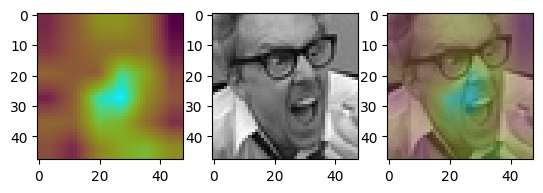

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)


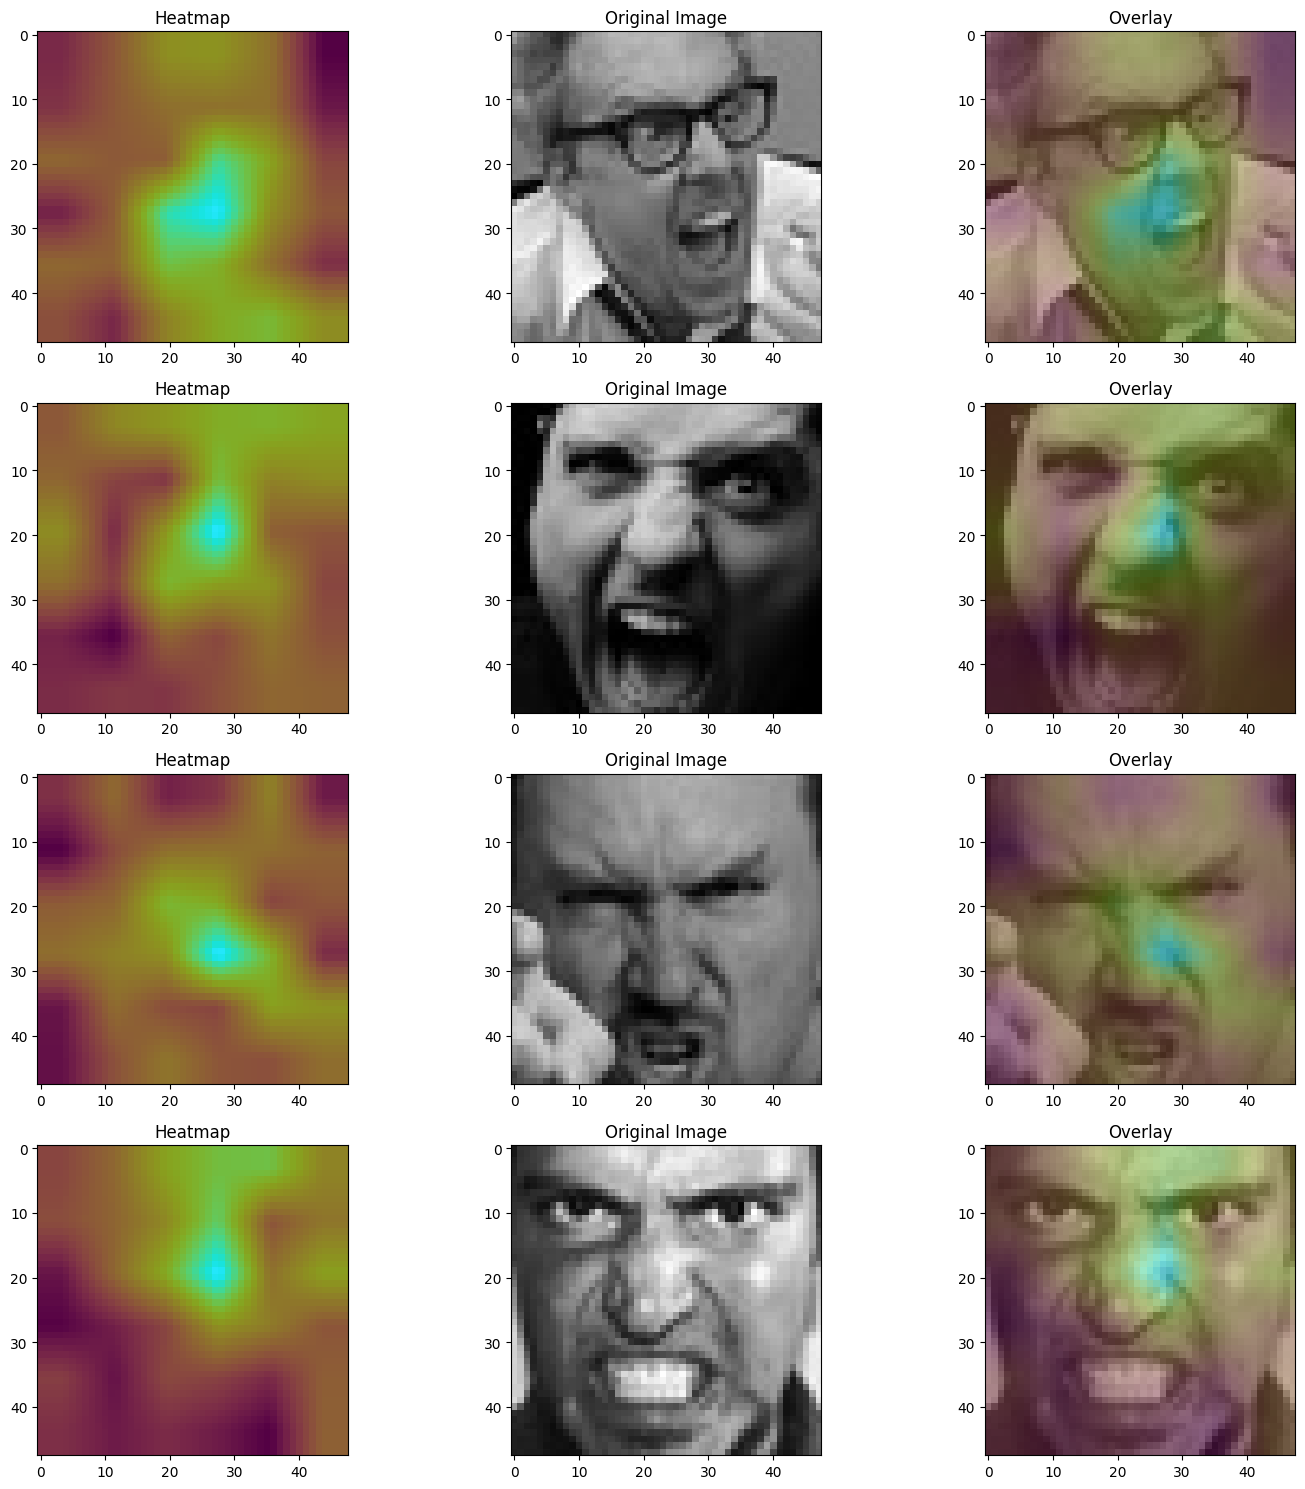

In [ ]:
image_paths = ['/content/drive/MyDrive/datasets/angry/1.jpg',
               '/content/drive/MyDrive/datasets/angry/2.jpg',
               '/content/drive/MyDrive/datasets/angry/3.jpg',
               '/content/drive/MyDrive/datasets/angry/4.jpg']

# Define the GradCAM instance
icam = GradCAM(loaded_model, i, 'conv3_block1_2_relu')

# Process each image and plot the results
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for i, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (48, 48))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)
    icam = GradCAM(loaded_model, i, 'conv3_block1_2_relu')
    # image = np.expand_dims(image, axis=0)
    heatmap = icam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (48, 48))

    image = cv2.imread(image_path)
    image = cv2.resize(image, (48, 48))
    print(heatmap.shape, image.shape)

    (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


    # Plot heatmap, original image, and overlay
    axes[i, 0].imshow(heatmap)
    axes[i, 0].set_title('Heatmap')
    axes[i, 1].imshow(image.squeeze())
    axes[i, 1].set_title('Original Image')
    axes[i, 2].imshow(output)
    axes[i, 2].set_title('Overlay')

plt.tight_layout()
plt.show()

(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)


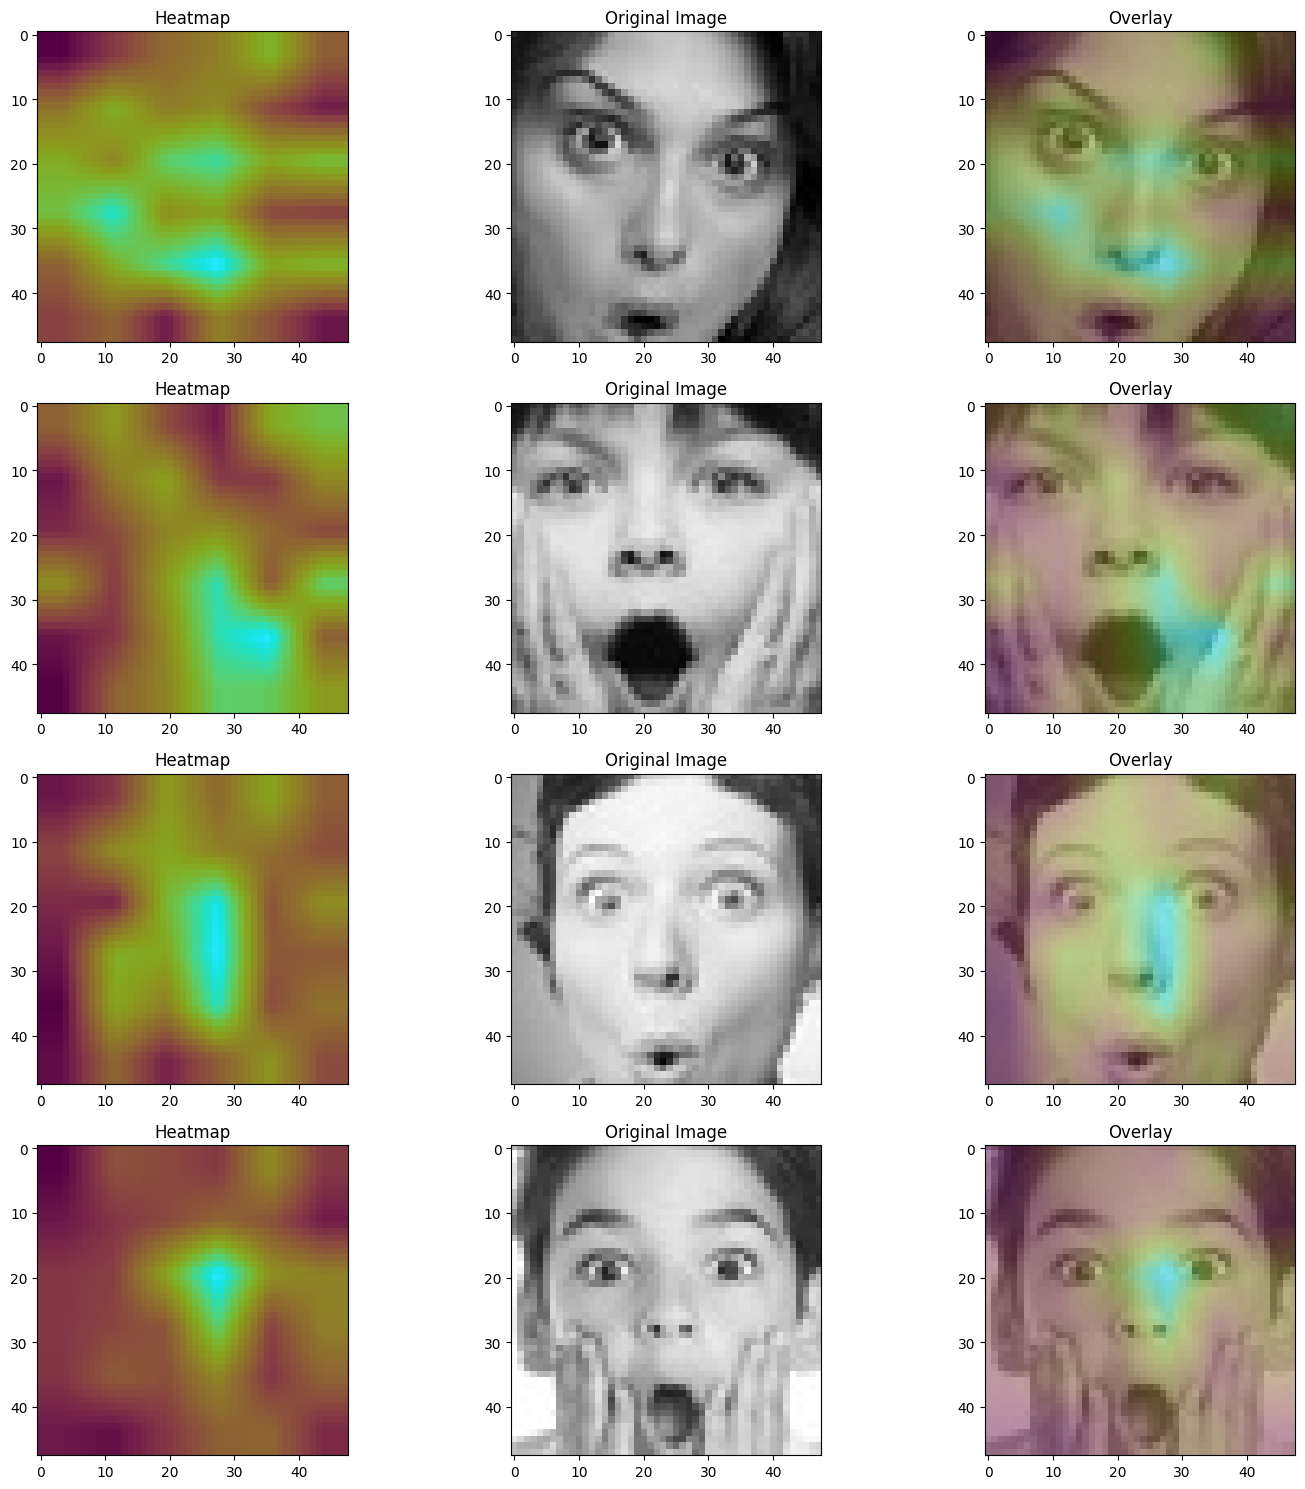

In [ ]:
image_paths = ['/content/drive/MyDrive/datasets/surprise/1.jpg',
               '/content/drive/MyDrive/datasets/surprise/2.jpg',
               '/content/drive/MyDrive/datasets/surprise/3.jpg',
               '/content/drive/MyDrive/datasets/surprise/4.jpg']

# Define the GradCAM instance
icam = GradCAM(loaded_model, i, 'conv3_block1_2_relu')

# Process each image and plot the results
fig, axes = plt.subplots(len(image_paths), 3, figsize=(15, 15))

for i, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (48, 48))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)
    icam = GradCAM(loaded_model, i, 'conv3_block1_2_relu')
    heatmap = icam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (48, 48))

    image = cv2.imread(image_path)
    image = cv2.resize(image, (48, 48))
    print(heatmap.shape, image.shape)

    (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


    # Plot heatmap, original image, and overlay
    axes[i, 0].imshow(heatmap)
    axes[i, 0].set_title('Heatmap')
    axes[i, 1].imshow(image.squeeze())
    axes[i, 1].set_title('Original Image')
    axes[i, 2].imshow(output)
    axes[i, 2].set_title('Overlay')

plt.tight_layout()
plt.show()

(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)
(48, 48) (48, 48, 3)


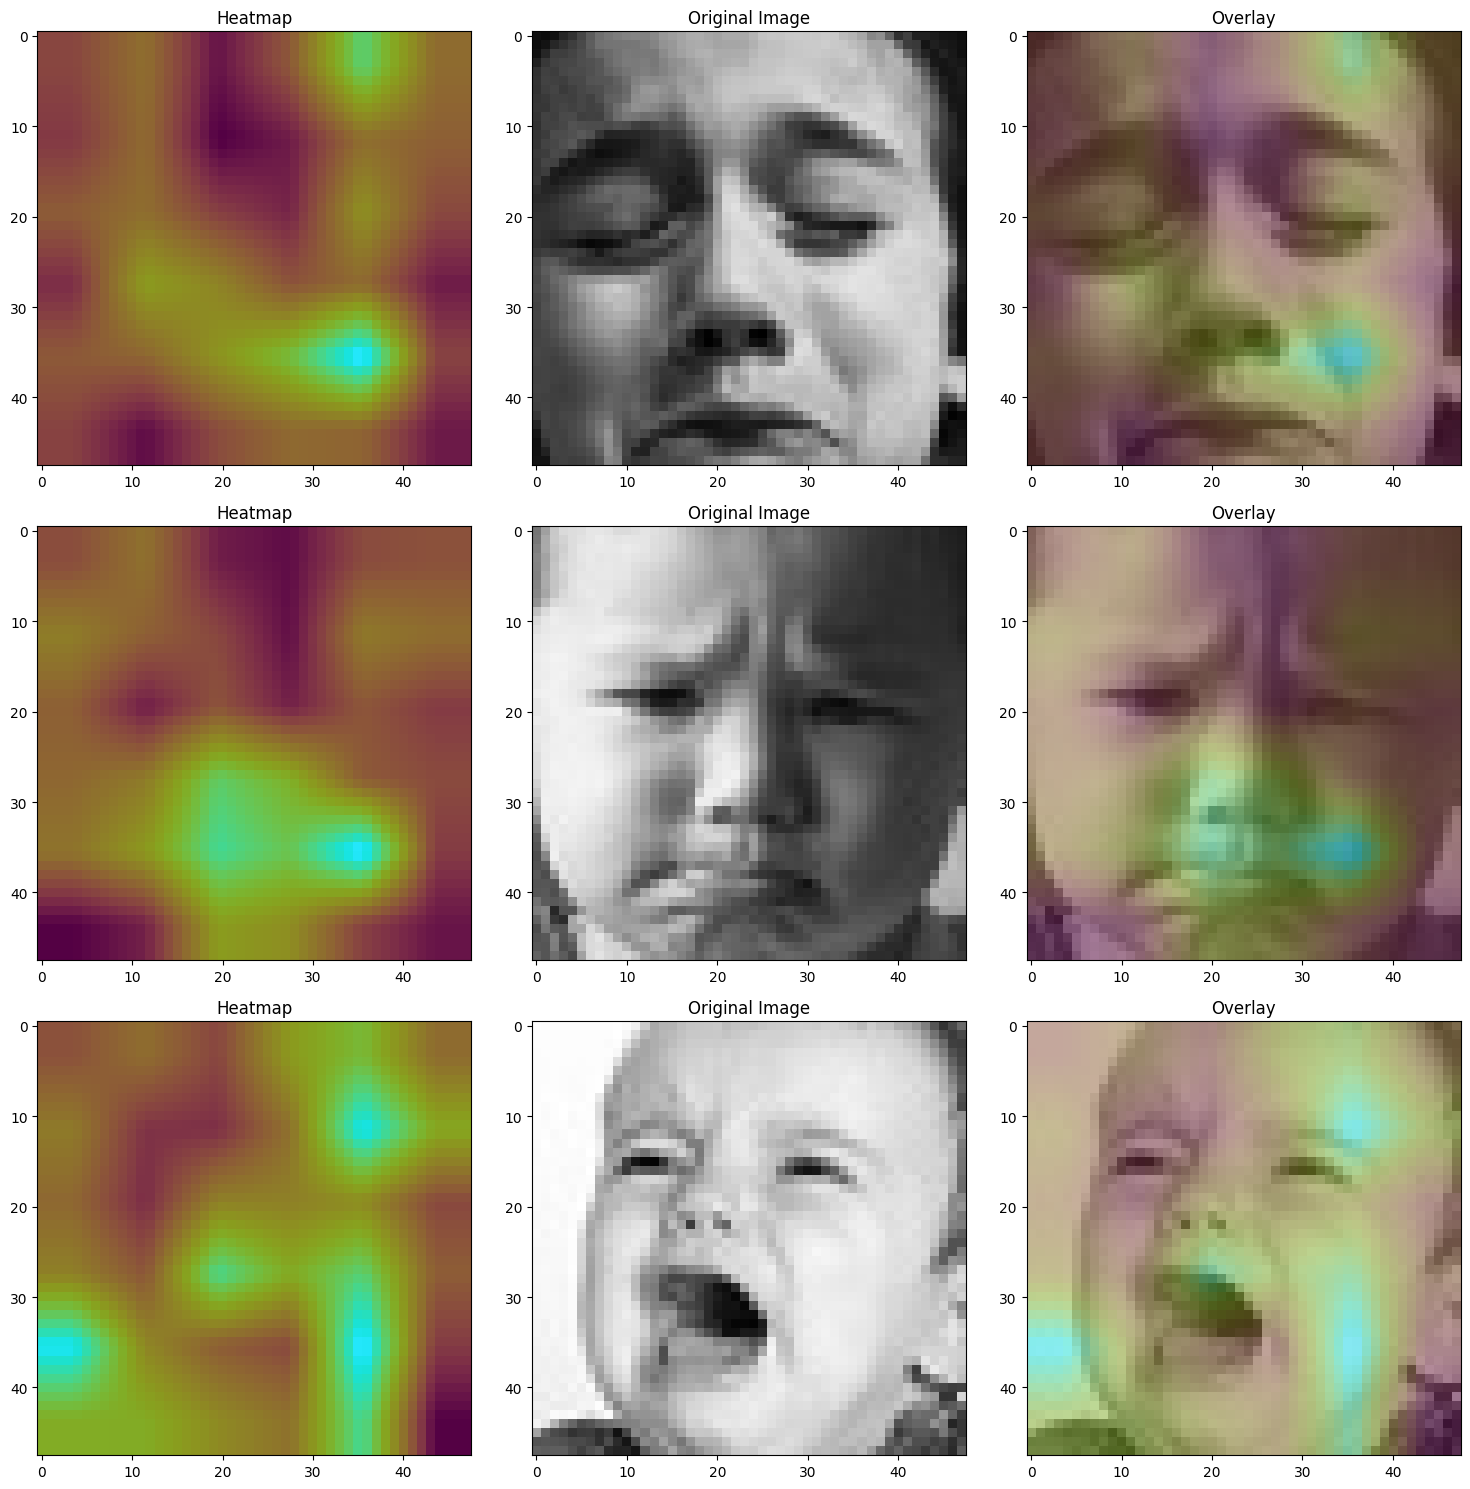

In [ ]:
image_paths = ['/content/drive/MyDrive/datasets/sad/1.jpg',
               '/content/drive/MyDrive/datasets/sad/2.jpg',
               '/content/drive/MyDrive/datasets/sad/3.jpg']

# Define the GradCAM instance
icam = GradCAM(loaded_model, i, 'conv3_block1_2_relu')

# Process each image and plot the results
fig, axes = plt.subplots(len(image_paths), 3, figsize=(15, 15))

for i, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (48, 48))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)
    icam = GradCAM(loaded_model, i, 'conv3_block1_2_relu')
    # image = np.expand_dims(image, axis=0)
    heatmap = icam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (48, 48))

    image = cv2.imread(image_path)
    image = cv2.resize(image, (48, 48))
    print(heatmap.shape, image.shape)

    (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


    # Plot heatmap, original image, and overlay
    axes[i, 0].imshow(heatmap)
    axes[i, 0].set_title('Heatmap')
    axes[i, 1].imshow(image.squeeze())
    axes[i, 1].set_title('Original Image')
    axes[i, 2].imshow(output)
    axes[i, 2].set_title('Overlay')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model

class GradCAMPlusPlus:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, self.classIdx]

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_sum(guidedGrads, axis=(0, 1))
        alpha_num = guidedGrads
        alpha_denom = guidedGrads * 2 + tf.reduce_sum(convOutputs * guidedGrads, axis=(0, 1), keepdims=True) * convOutputs
        alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones_like(alpha_denom))
        alphas = alpha_num / alpha_denom

        alpha_normalization_constant = tf.reduce_sum(alphas, axis=(0, 1), keepdims=True)
        alphas /= alpha_normalization_constant

        weights = tf.reduce_sum(weights * alphas, axis=(0, 1))

        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)


In [ ]:
# Define the path to your checkpoint file
checkpoint_path = '/content/drive/MyDrive/datasets/model_best1.h5'

custom_objects = {'f1_score': f1_score, 'accuracy': tf.keras.metrics.BinaryAccuracy(name='accuracy'), \
                  'Precision': tf.keras.metrics.Precision(name='precision'), \
                  'Recall': tf.keras.metrics.Recall(name='recall'), \
                  'AUC': tf.keras.metrics.AUC(name='auc')}

# Load the model
loaded_model = load_model(checkpoint_path, custom_objects=custom_objects)

In [ ]:
image = cv2.imread('/content/PrivateTest_4129990.jpg')
image = cv2.resize(image, (48, 48))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = loaded_model.predict(image)
i = np.argmax(preds[0])

1/1 [==============================] - 0s 69ms/step


In [ ]:
i

0

In [ ]:
image = cv2.imread('/content/PrivateTest_4129990.jpg')
image = cv2.resize(image, (48, 48))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
icam = GradCAMPlusPlus(loaded_model, i, 'conv2_block1_1_conv')
# image = np.expand_dims(image, axis=0)
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (48, 48))

image = cv2.imread('/content/PrivateTest_4129990.jpg')
image = cv2.resize(image, (48, 48))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(48, 48) (48, 48, 3)
